In [21]:
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torchvision
import cv2
import torch.nn as nn
import nibabel as nib

In [22]:
os.chdir("G:/rsna-2023-abdominal-trauma-detection/")

In [23]:
os.listdir()

['224files',
 '224_train_liver.csv',
 '224_train_spleen.csv',
 '2301.00785CLIP-Universal.pdf',
 '2308.16184SAM-Med2D.pdf',
 'all_slice_df.csv',
 'cropped_images',
 'cropped_images_256',
 'cropped_images_3ch',
 'cropped_images_resize',
 'cropped_organs',
 'cropped_organs_gt',
 'cropped_organs_gt_inferred',
 'cropped_organs_ill',
 'cropped_organs_sid',
 'cropped_train_bowel.csv',
 'cropped_train_bowel_3ch.csv',
 'cropped_train_bowel__25d.csv',
 'cropped_train_kidney.csv',
 'cropped_train_liver.csv',
 'cropped_train_lkidney_3ch.csv',
 'cropped_train_lkidney_3ch1.csv',
 'cropped_train_lkidney_3ch2.csv',
 'cropped_train_lkidney_3ch3.csv',
 'cropped_train_rkidney_3ch1.csv',
 'cropped_train_rkidney_3ch2.csv',
 'cropped_train_rkidney_3ch3.csv',
 'cropped_train_spleen.csv',
 'custom_rcnn_epoch_4.pth',
 'data.txt',
 'efficientnet-b0_109_fold0_epoch0.pth',
 'efficientnet-b0_109_fold0_epoch1.pth',
 'efficientnet-b0_109_fold0_epoch2.pth',
 'efficientnet-b0_109_fold0_epoch3.pth',
 'image_level_label

In [24]:
import pydicom as dicom

def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data

In [25]:
p_s = glob("G:/rsna-2023-abdominal-trauma-detection/train_images/*/*")
s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in p_s}
len(p_s)

4711

#### check cropped file count for each sid

In [26]:
# for check_sid in  tqdm(s_id_p_id.keys()):
#     if len(glob(f"./cropped_images_3ch/*_{check_sid}_*_*.jpeg")) != 125:
#         print(s_id_p_id[check_sid],check_sid,len(glob(f"./cropped_images_3ch/*_{check_sid}_*_*.jpeg")))

#### display true segmentation

In [27]:
seg_files = glob("./segmentations/*.nii")
len(seg_files)

206

In [28]:
gt_sid = seg_files[180].split("\\")[-1].split(".")[0]
gt_pid = s_id_p_id[gt_sid]

(284, 512, 512)


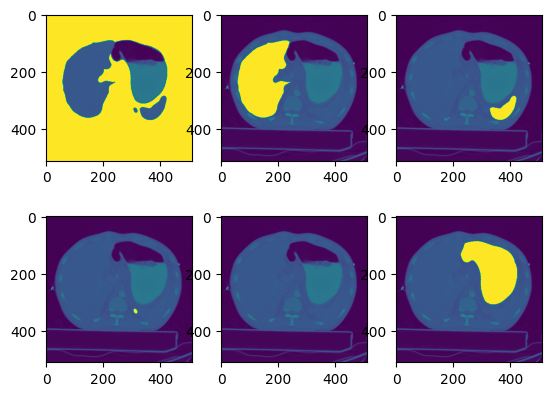

In [29]:
dcm_files = glob(f"./train_images/{gt_pid}/{gt_sid}/*.dcm")
dcm_ids = sorted([int(x.split("\\")[-1].split(".")[0]) for x in dcm_files])
mask_img = nib.load(f"./segmentations/{gt_sid}.nii").get_fdata()[:, ::-1, ::-1].transpose(2,1, 0)
slice_n = np.where(mask_img==3)[0][10]
print(mask_img.shape)
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    img_data = load_dicom(f"./train_images/{gt_pid}/{gt_sid}/{dcm_ids[slice_n]}.dcm")
    tt_img = mask_img==ii
    plt.imshow(np.where(np.array(tt_img)[slice_n],np.array(tt_img)[slice_n],img_data))

False True
False True
False True
False True
False True
False True


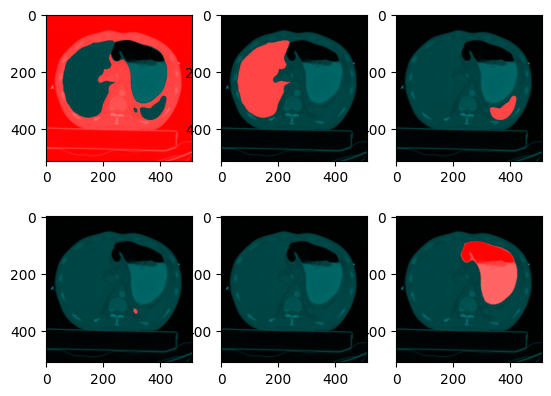

In [10]:

for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    img_data = load_dicom(f"./train_images/{gt_pid}/{gt_sid}/{dcm_ids[slice_n]}.dcm")
    tt_img = mask_img==ii
    print(tt_img.min(),tt_img.max())
    plt.imshow(np.stack([tt_img[slice_n],img_data,img_data],axis=2).astype(np.float32))

In [11]:
np.where((mask_img==5).sum(0).sum(0)>0)

(array([125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
        177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
        203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
        216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
        229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
        242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
        255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
        268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
        281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293,
        294, 295, 296, 297, 298, 299, 300, 301, 302

In [12]:
# cls 3 lkidney 300.0794, 345.5285
# cls 2 spleen 304, 380
# cls 5 bowel 214 287
# cls 1 liver 239 180
# cls 4 rkidney 183,183

In [13]:
trn_df = pd.read_csv("./train.csv")

In [14]:
s_ids = s_id_p_id.keys()

p_ids = [int(s_id_p_id[x]) for x in s_ids]
p_s_df = pd.DataFrame({"series_id":s_ids,"patient_id":p_ids})


In [15]:
np.sum(trn_df.extravasation_injury.values), np.sum(trn_df.extravasation_healthy.values), \
np.sum(trn_df.bowel_injury.values), np.sum(trn_df.bowel_healthy.values), \
np.sum(trn_df.liver_high.values), np.sum(trn_df.liver_low.values), np.sum(trn_df.liver_healthy.values), \
np.sum(trn_df.spleen_high.values), np.sum(trn_df.spleen_low.values), np.sum(trn_df.spleen_healthy.values), \
np.sum(trn_df.kidney_low.values),

(200, 2947, 64, 3083, 62, 259, 2826, 155, 199, 2793, 115)

In [16]:
trn_df = trn_df.merge(p_s_df, on="patient_id",how="left")
trn_df.shape

(4711, 16)

(512, 512) 1.0 0.0
(512, 512) 0.0 1.0 (512, 512, 3) 0 255


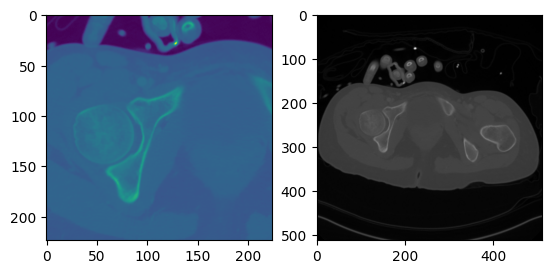

In [17]:
import pydicom as dicom

images_coords = [239-112, 180-112]
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data
image_paths = glob(f"./train_images/{trn_df.iloc[1000].patient_id}/*/*.dcm")
# image_paths = glob(f"./224files/{trn_df.iloc[800].patient_id}*.jpeg")
# image_paths = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/{trn_df.iloc[800].patient_id}/*/*.jpeg")
img = load_dicom(image_paths[100])
# img = cv2.imread(image_paths[10])
print(img.shape, img.max(), img.min())
plt.subplot(1,2,1)
plt.imshow(img[images_coords[0]:images_coords[0]+224,images_coords[1]:images_coords[1]+224])
plt.subplot(1,2,2)
plt.imshow(img)
cv2.imwrite("tmp.jpeg", img*255)
saved_img = cv2.imread("tmp.jpeg")
print(img.shape,img.min(),img.max(),saved_img.shape,saved_img.min(),saved_img.max())
plt.imshow(saved_img)

In [18]:
# for ii in range(100):
#     if len(glob(f"./segmentations/{trn_df.iloc[1000+ii].series_id}.nii")):
#         print(trn_df.iloc[1000+ii])

In [19]:
target_dir = "./cropped_organs_sid"
import shutil
for folder in tqdm(glob(f"{target_dir}/*/*")):
    if len(os.listdir(folder))==0:
        print("removing", folder)
        shutil.rmtree(folder)
    # else:print("has data")
for folder in glob(f"{target_dir}/*"):
    if len(os.listdir(folder))==0:
        print("removing", folder)
        shutil.rmtree(folder)

100%|██████████| 4711/4711 [00:01<00:00, 4427.63it/s]


In [20]:
copied_sids = [str(x.split("\\")[-1]) for x in glob(f"{target_dir}/*/*")]
copy_df = trn_df[~trn_df.series_id.isin(copied_sids)]
copy_df = copy_df.reset_index(drop=True)
print("to copy", len(copy_df))
base_dir = "D:/cropped_organs_img/"

cls_counts =[[],[],[],[],[]]

total_files = glob(f"D:/cropped_organs_img/*_*_*_*.jpeg")
file_by_series = dict()
for file in tqdm(total_files):
    sid = file.split("_")[-3]
    if sid not in file_by_series.keys():
        file_by_series[sid] = [file]
    else:
        file_by_series[sid].append(file)
file_by_series
for c_sid in tqdm(file_by_series.keys()):
    c_pid = s_id_p_id[c_sid]
    # print(c_pid,c_sid)
    if not os.path.exists(f"{target_dir}/{c_pid}"):
        os.mkdir(f"{target_dir}/{c_pid}")
    if not os.path.exists(f"{target_dir}/{c_pid}/{c_sid}"):
        os.mkdir(f"{target_dir}/{c_pid}/{c_sid}")
    for series_file in file_by_series[c_sid]:
        shutil.copy(series_file,f"{target_dir}/{c_pid}/{c_sid}")
    for cls_id in range(5):
        cls_counts[cls_id].append(len(glob(f"{target_dir}/{c_pid}/{c_sid}/*_{cls_id+1}_*.jpeg")))


to copy 0


  0%|          | 10/2640 [00:05<22:09,  1.98it/s]


KeyboardInterrupt: 

#### partiion healthy / ill organs

In [ ]:
liver_low_sids = trn_df[trn_df.liver_low==1].series_id.values
liver_high_sids = trn_df[trn_df.liver_high==1].series_id.values
liver_healthy_sids = trn_df[trn_df.liver_healthy==1].series_id.values
print(len(liver_healthy_sids),len(liver_low_sids),len(liver_high_sids))

spleen_low_sids = trn_df[trn_df.spleen_low==1].series_id.values
spleen_high_sids = trn_df[trn_df.spleen_high==1].series_id.values
spleen_healthy_sids = trn_df[trn_df.spleen_healthy==1].series_id.values
print(len(spleen_healthy_sids),len(spleen_low_sids),len(spleen_high_sids))

kidney_low_sids = trn_df[trn_df.kidney_low==1].series_id.values
kidney_high_sids = trn_df[trn_df.kidney_high==1].series_id.values
kidney_healthy_sids = trn_df[trn_df.kidney_healthy==1].series_id.values
print(len(kidney_healthy_sids),len(kidney_low_sids),len(kidney_high_sids))

extravasation_injury_sids = trn_df[trn_df.extravasation_injury==1].series_id.values
extravasation_healthy_sids = trn_df[trn_df.extravasation_healthy==1].series_id.values
print(len(extravasation_healthy_sids),len(extravasation_injury_sids))

bowel_injury_sids = trn_df[trn_df.bowel_injury==1].series_id.values
bowel_healthy_sids = trn_df[trn_df.bowel_healthy==1].series_id.values
len(bowel_healthy_sids),len(bowel_injury_sids)

4236 384 91
4166 316 229
4426 176 109
4411 300


(4607, 104)

4607


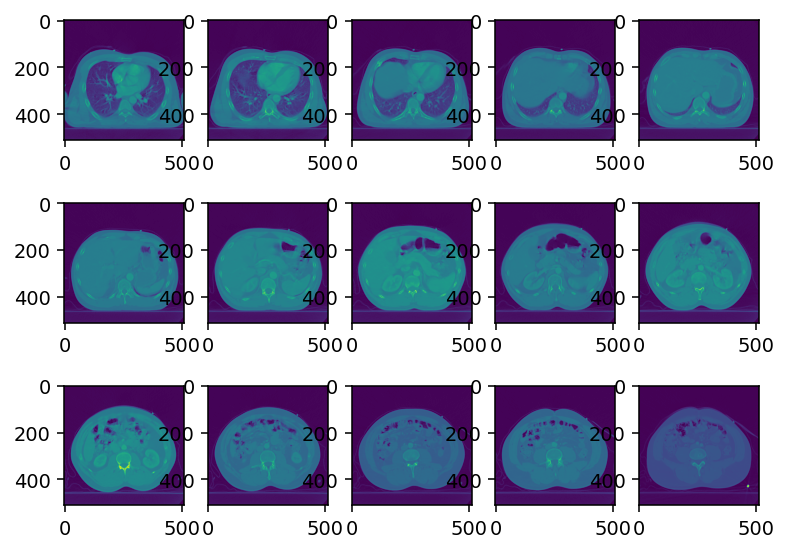

In [ ]:
dcm_folders = glob(f"./train_images/*/*")
import matplotlib
matplotlib.rcParams['figure.dpi'] = 140

dcm_folders = [x for x in dcm_folders if x.split("\\")[-1] in bowel_healthy_sids]
print(len(dcm_folders))
show_dcm = glob(f"{np.random.choice(dcm_folders)}/*.dcm")
dcm_files = sorted(show_dcm, key=lambda x: int(x.split("\\")[-1].split(".")[0]))
for ii in range(15):
    idx = int(len(dcm_files)/15*ii)
    plt.subplot(3,5,ii+1);
    plt.imshow(load_dicom(dcm_files[idx]))

104


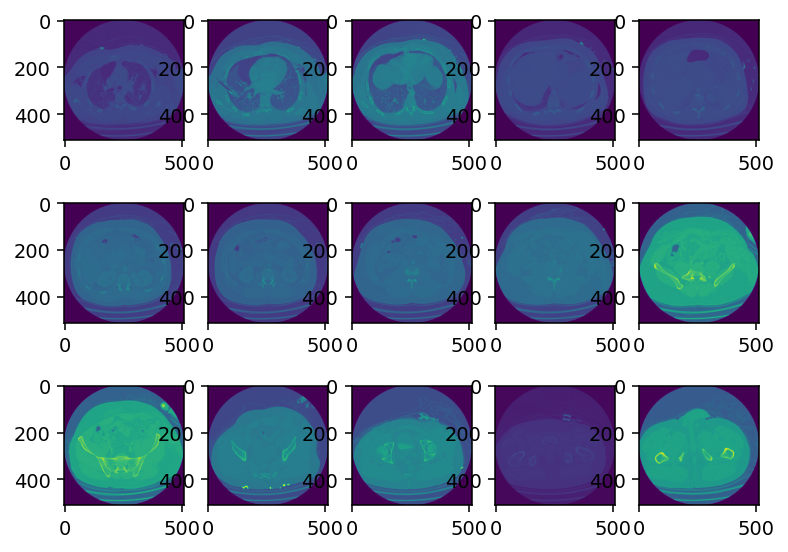

In [ ]:
dcm_folders = glob(f"./train_images/*/*")
import matplotlib
matplotlib.rcParams['figure.dpi'] = 140

dcm_folders = [x for x in dcm_folders if x.split("\\")[-1] in bowel_injury_sids]
print(len(dcm_folders))
show_dcm = glob(f"{np.random.choice(dcm_folders)}/*.dcm")
dcm_files = sorted(show_dcm, key=lambda x: int(x.split("\\")[-1].split(".")[0]))
for ii in range(15):
    idx = int(len(dcm_files)/15*ii)
    plt.subplot(3,5,ii+1);
    plt.imshow(load_dicom(dcm_files[idx]))

384
./train_images\4477\26376


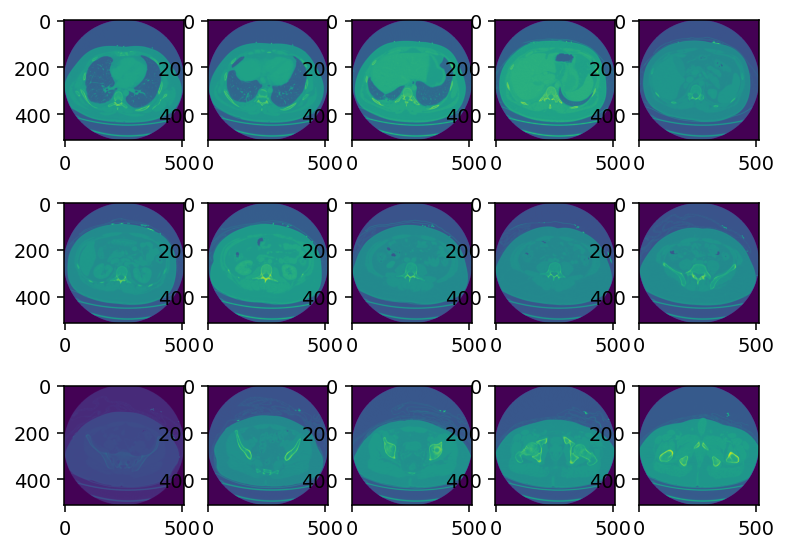

In [ ]:
dcm_folders = glob(f"./train_images/*/*")
dcm_folders = [x for x in dcm_folders if x.split("\\")[-1] in liver_low_sids]
print(len(dcm_folders))
show_dcm = np.random.choice(dcm_folders)
print(show_dcm)
dcm_files = sorted(glob(f"{show_dcm}/*.dcm"), key=lambda x: int(x.split("\\")[-1].split(".")[0]))
for ii in range(15):
    idx = int(len(dcm_files)/15*ii)
    plt.subplot(3,5,ii+1);
    plt.imshow(load_dicom(dcm_files[idx]))

1
./train_images/11217/48987


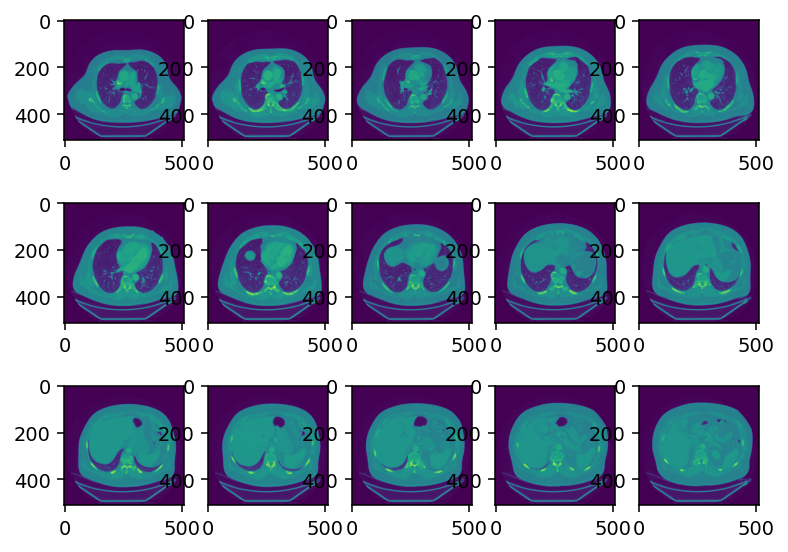

In [ ]:
dcm_folders = glob(f"./train_images/11217/48987")
# dcm_folders = [x for x in dcm_folders if x.split("\\")[-1] in bowel_injury_sids]
print(len(dcm_folders))
show_dcm = np.random.choice(dcm_folders)
print(show_dcm)
dcm_files = sorted(glob(f"{show_dcm}/*.dcm"), key=lambda x: int(x.split("\\")[-1].split(".")[0]))
for ii in range(15):
    idx = int(len(dcm_files)/15*ii)
    plt.subplot(3,5,ii+1);
    plt.imshow(load_dicom(dcm_files[idx]))

4236
./train_images\51298\42103 648
./train_images\51298\42103
[[51298 1 0 1 0 1 0 0 1 0 0 1 0 0 0 '42103']]


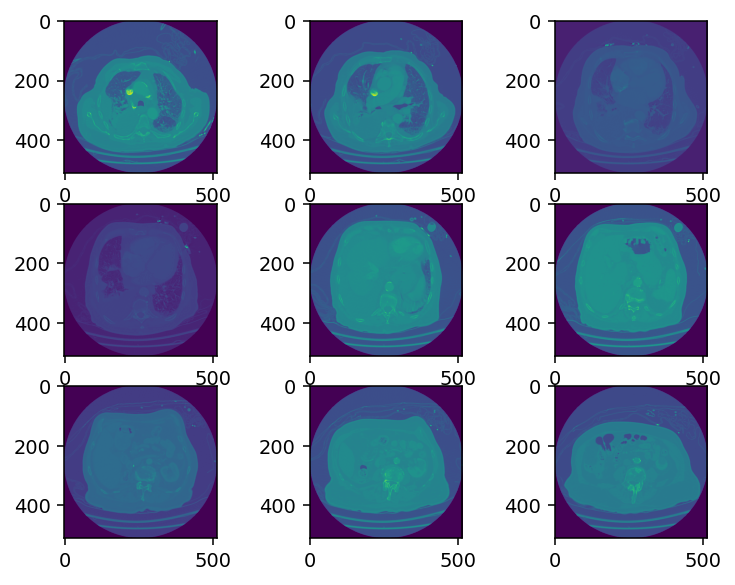

In [ ]:
dcm_folders = glob(f"./train_images/*/*")
dcm_folders = [x for x in dcm_folders if x.split("\\")[-1] in liver_healthy_sids]
print(len(dcm_folders))
show_dcm = np.random.choice(dcm_folders)
print(show_dcm,len(glob(f"{show_dcm}/*.dcm")))
print(show_dcm)
sid = show_dcm.split("\\")[-1]
print(trn_df[trn_df.series_id==sid].values)
dcm_files = sorted(glob(f"{show_dcm}/*.dcm"), key=lambda x: int(x.split("\\")[-1].split(".")[0]))
for ii in range(9):
    idx = int(len(dcm_files)/15*ii)+6
    plt.subplot(3,3,ii+1);
    plt.imshow(load_dicom(dcm_files[idx]))

384
./train_images\49350\41306 218
[[49350 1 0 1 0 1 0 0 0 1 0 1 0 0 1 '41306']]


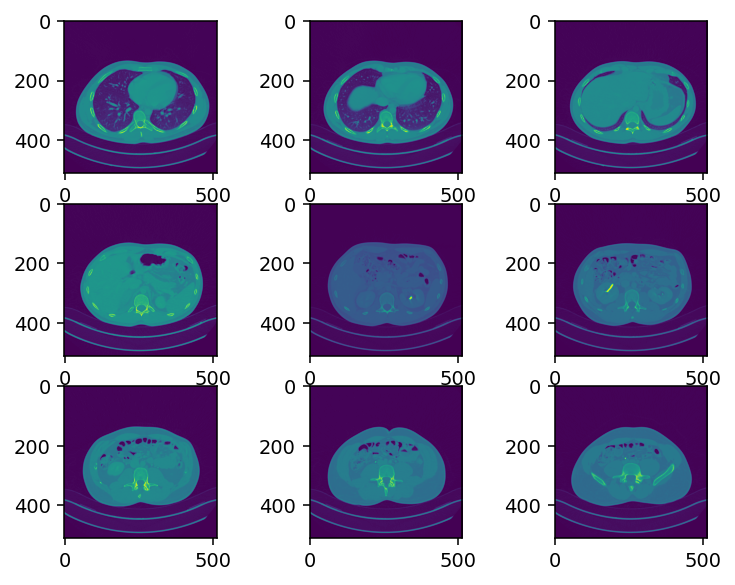

In [ ]:
dcm_folders = glob(f"./train_images/*/*")
dcm_folders = [x for x in dcm_folders if x.split("\\")[-1] in liver_low_sids]
print(len(dcm_folders))
show_dcm = np.random.choice(dcm_folders)
print(show_dcm,len(glob(f"{show_dcm}/*.dcm")))
sid = show_dcm.split("\\")[-1]
print(trn_df[trn_df.series_id==sid].values)
dcm_files = sorted(glob(f"{show_dcm}/*.dcm"), key=lambda x: int(x.split("\\")[-1].split(".")[0]))
for ii in range(9):
    idx = int(len(dcm_files)/15*ii)+3
    plt.subplot(3,3,ii+1);
    plt.imshow(load_dicom(dcm_files[idx]))

In [ ]:
base_folder= "G:/rsna-abdominal-2023/reduced_512_tickness_5"
base_folder = "./cropped_organs/"

In [66]:
# cropped_sids = np.unique([x.split("_")[-3] for x in glob("./224files/*")])
# cropped_sids = np.unique([x.split("_")[-3] for x in glob("./cropped_images_3ch/*")])

# cropped_sids = np.unique([x.split("_")[-3] for x in glob("./cropped_organs/*")])
cropped_sids = np.unique([x.split("\\")[-1] for x in glob("./cropped_organs_sid/*/*")])
# cropped_sids = np.unique([x.split("_")[-3] for x in glob("D:/cropped_organs_img/*.jpeg")])
# cropped_sids = np.unique([x.split("\\")[-1] for x in glob(f"{base_folder}/[0-9]*/*")])
# cropped_sids = np.unique([x.split("\\")[-1].split(".")[-2] for x in glob("./segmentations/*")])
kidney_sids = np.unique([x.split("_")[-3] for x in glob("./cropped_images/*_3_*")])
len(kidney_sids),len(cropped_sids)


(2898, 4711)

In [67]:
liver_low_sids = [x for x in liver_low_sids if x in cropped_sids]
liver_high_sids = [x for x in liver_high_sids if x in cropped_sids]
liver_healthy_sids = [x for x in liver_healthy_sids if x in cropped_sids]
print("liver", len(liver_healthy_sids),len(liver_low_sids),len(liver_high_sids))

spleen_low_sids = [x for x in spleen_low_sids if x in cropped_sids]
spleen_high_sids = [x for x in spleen_high_sids if x in cropped_sids]
spleen_healthy_sids = [x for x in spleen_healthy_sids if x in cropped_sids]
print("spleen", len(spleen_healthy_sids),len(spleen_low_sids),len(spleen_high_sids))

kidney_low_sids = [x for x in kidney_low_sids if x in cropped_sids]
kidney_high_sids = [x for x in kidney_high_sids if x in cropped_sids]
kidney_healthy_sids = [x for x in kidney_healthy_sids if x in cropped_sids]
print("kidney", len(kidney_healthy_sids),len(kidney_low_sids),len(kidney_high_sids))

bowel_injury_sids = [x for x in bowel_injury_sids if x in cropped_sids]
bowel_healthy_sids = [x for x in bowel_healthy_sids if x in cropped_sids]
print("bowel", len(bowel_injury_sids),len(bowel_healthy_sids))

extravasation_injury_sids = [x for x in extravasation_injury_sids if x in cropped_sids]
extravasation_healthy_sids = [x for x in extravasation_healthy_sids if x in cropped_sids]
print("extravasation", len(extravasation_injury_sids),len(extravasation_healthy_sids))

4236 384 91
4166 316 229
4426 176 109
104 4607
300 4411


In [ ]:
# os.mkdir(f"D:/cropped_organs_by_ill")
# os.mkdir(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/liver_healthy")
# os.mkdir(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/liver_low")
# os.mkdir(f"{base_folder}/liver_high")

# os.mkdir(f"{base_folder}/spleen_healthy")
# os.mkdir(f"{base_folder}/spleen_low")
# os.mkdir(f"{base_folder}/spleen_high")
# os.mkdir(f"{base_folder}/kidney_healthy")
# os.mkdir(f"{base_folder}/kidney_low")
# os.mkdir(f"{base_folder}/kidney_high")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'G:/rsna-abdominal-2023/reduced_512_tickness_5/kidney_healthy'

In [ ]:
# from glob import glob
# seg_ids = [int(x.split("\\")[-1].split(".")[0]) for x in seg_files]
# # seg_ids
# [x for x in seg_ids if len(glob(f"./cropped_images/*_{x}_*"))>0]

In [25]:
import shutil
base_folder= "G:/rsna-2023-abdominal-trauma-detection/cropped_organs_sid/"
# base_folder= "D:/cropped_organs_sid/"
# copied_sid = [x.split("_")[-3] for x in glob(f"{base_folder}/liver_low/*")]
target_folder= "G:/rsna-2023-abdominal-trauma-detection/cropped_organs_ill/"
# target_folder= "D:/cropped_organs_ill/"
# to_copy = [x for x in liver_low_sids if str(x) not in copied_sid]
# print(len(copied_sid),len(to_copy),len(liver_low_sids))
seg_cls = "2"
for tmp_sid in tqdm(spleen_healthy_sids[:]):
    # print(liver_sid)
    tmp_pid = s_id_p_id[str(tmp_sid)]
    files = glob(f"{base_folder}/{tmp_pid}/{tmp_sid}/*_*_{seg_cls}_*.jpeg*")
    
    for file in files:
        file_name = file.split(".")[-2].split("\\")[-1]
        # print(file_name)
        shutil.copy(file, f"{target_folder}/spleen_healthy/{tmp_pid}_{tmp_sid}_{seg_cls}_{file_name}.jpeg")


  1%|▏         | 56/4166 [00:05<06:47, 10.10it/s]


KeyboardInterrupt: 

In [39]:
x = [[1,1],[2,1]]
x / np.linalg.norm(x,axis=1)[:,None]
np.exp(0.4)
x = np.exp(np.array([[1,2,3],[4,5,6]]))-1
x / np.linalg.norm(x,axis=1)[:,None]

array([[0.08506447, 0.31629368, 0.94483985],
       [0.12409362, 0.3412997 , 0.93172705]])

In [ ]:
import shutil
# copied_sid = [x.split("_")[-3] for x in glob("D:/cropped_organs_by_ill/liver_low/*")]

# to_copy = [x for x in liver_low_sids if str(x) not in copied_sid]
# print(len(copied_sid),len(to_copy),len(liver_low_sids))
for liver_sid in tqdm(kidney_low_sids[:]):
    # print(liver_sid)
    liver_files = glob(f"{base_folder}/*_{liver_sid}_3_*.jpeg*")
    print(len(liver_files))
    for liver_file in liver_files:
        shutil.copy(liver_file, f"{base_folder}/kidney_low/")


process 16618 63074
0.0 1.0
process 10004 21057
has coord npy
0.0 1.0
process 34132 41652
0.0 1.0
process 21264 27566
0.0 1.0
process 36944 57098
0.0 1.0
process 40496 64369
0.0 1.0


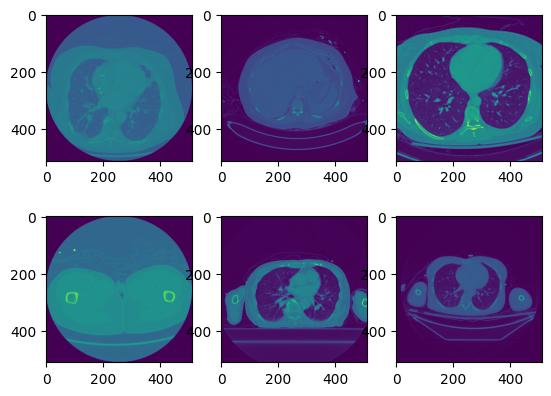

In [25]:
images_coords = [239-112, 180-112]
for ii in range(6):
    gt_sid = np.random.choice(liver_healthy_sids)
    gt_pid = s_id_p_id[gt_sid]
    image_paths = glob(f"./train_images/{gt_pid}/{gt_sid}/*.dcm")
    image_paths = sorted(image_paths,key=lambda x:int(x.split("\\")[-1].replace(".dcm","")))
    img_idx = 0
    print("process", gt_pid,gt_sid)
    if len(glob(f"./224files/{gt_pid}_{gt_sid}_coord.npy")):
        coords = np.load(glob(f"./224files/{gt_pid}_{gt_sid}_coord.npy")[0])
        print("has coord npy")
        img_idx = coords[0][0] 
    elif len(glob(f"./segmentations/{gt_sid}.nii")):
        print("has seg nii")
        masks = nib.load(glob(f"./segmentations/{gt_sid}.nii")[0])
        img_idx = np.where(masks==1)[0][0]
    # image_paths = glob(f"./224files/{trn_df.iloc[800].patient_id}*.jpeg")
    # image_paths = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/{trn_df.iloc[800].patient_id}/*/*.jpeg")
    img = load_dicom(image_paths[img_idx])
    print(img.min(),img.max())
    plt.subplot(2,3,ii+1)
    plt.imshow(img)

22726 26627 77 182
37338 3542 0 190
35659 2165 77 255
18413 28978 51 204
48052 42092 70 255
25173 18194 114 255


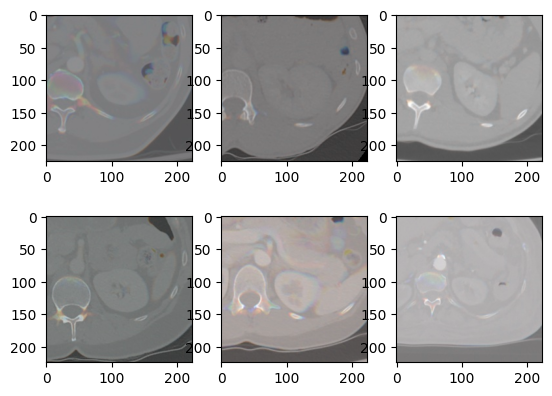

In [26]:

images_coords = [239-112, 180-112] #liver
folder = "cropped_images_3ch"
for ii in range(6):
    gt_sid = np.random.choice(kidney_healthy_sids)
    gt_pid = s_id_p_id[gt_sid]
    # gt_sid = glob(f"./train_images/{gt_pid}/*")[0].split("\\")[-1]
    img = cv2.imread(glob(f"./{folder}/{gt_pid}_{gt_sid}_{3}_*.jpeg")[0])
    print(gt_pid, gt_sid, img.min(),img.max())
    plt.subplot(2,3,ii+1)
    plt.imshow(img)

38982 8340 0 236
36105 63701 0 255
21411 39864 0 154
51192 64719 0 255
51192 28238 183 255
7754 56068 0 255


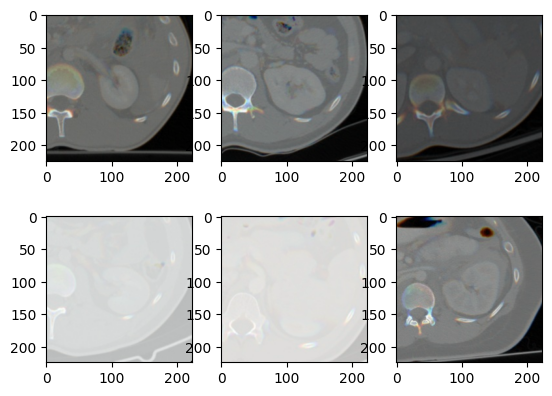

In [27]:

images_coords = [239-112, 180-112] #liver
folder = "cropped_images_3ch"
for ii in range(6):
    gt_sid = np.random.choice(kidney_low_sids)
    gt_pid = s_id_p_id[gt_sid]
    # gt_sid = glob(f"./train_images/{gt_pid}/*")[0].split("\\")[-1]
    img = cv2.imread(glob(f"./{folder}/{gt_pid}_{gt_sid}_{3}_*.jpeg")[0])
    print(gt_pid, gt_sid, img.min(),img.max())
    plt.subplot(2,3,ii+1)
    plt.imshow(img)

In [28]:
os.getcwd()

'G:\\rsna-2023-abdominal-trauma-detection'

#### show mmdet / efficientnet diff and substitue incorrectly cropped images

In [29]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name="efficientnet-b0",    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=5,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to("cuda")
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path)["model"])
    model.eval()
    return model

model = load_model("./efficientnet-b0_109_fold0_epoch2.pth")
model = model.eval()
def get_mask_smp(input_image):
    input_image = np.expand_dims(input_image.transpose(2,0,1),0).astype(np.float32)
    with torch.no_grad():
        y_pred = model(torch.from_numpy(input_image).to(torch.float32).cuda())
    y_pred = y_pred.sigmoid() ####
    y_pred = (y_pred).to('cpu').numpy()
    slice_pred = y_pred[0] # num_classes * img_size * img_size
    slice_mask_argmax = slice_pred.argmax(0) # img_size * img_size
    slice_mask_max = slice_pred.max(0) # img_size * img_size
    # print(exa_image.shape)
    slice_mask = np.where(slice_mask_max>0.5, slice_mask_argmax,0).astype(np.uint8)
    return slice_mask

In [30]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
config = 'E:\mmdetection-master\mmdetection-master\work_dirs/rsna/rsna.py'
checkpoint = 'E:\mmdetection-master\mmdetection-master\work_dirs/rsna/epoch_2.pth'
mmdet_model = init_detector(config, checkpoint, device='cuda:0')

def get_mask_mmdet(img_path):
    result = inference_detector(mmdet_model, img_path)
    mmdet_pred = np.array([np.sum(x,axis=0) if len(x)>0 else np.zeros((512,512)) for x in result[1]])
    mmdet_mask_argmax = mmdet_pred.argmax(0) # img_size * img_size
    mmdet_mask_max = mmdet_pred.max(0) # img_size * img_size
    mmdet_mask = np.where(mmdet_mask_max>0.5, mmdet_mask_argmax, 0).astype(np.uint8)
    return mmdet_mask

e:\Anaconda\envs\tt\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


load checkpoint from local path: E:\mmdetection-master\mmdetection-master\work_dirs/rsna/epoch_2.pth


In [31]:
r_pid,r_sid = "10556","17060"
r_folder = "_3ch"
rewrite_ids = [x.split("_")[-1].split(".")[0] for x in \
               glob(f"./cropped_images{r_folder}/{r_pid}_{r_sid}_3_*")]

base_path = f"./train_images/{r_pid}/{r_sid}"
dcm_indices = ([int(x.split("\\")[-1].split(".")[0]) for x in glob(f"{base_path}/*.dcm")])
min_dcm_idx = min(dcm_indices)
len_dcm = len(dcm_indices)
def create_3ch_image(img_id):
    img_list = []
    # img_shape = load_dicom(f"{base_path}/{min_dcm_idx+int(img_id)}.dcm").shape
    for jj in range(3):
        if (img_id == 0 and jj==0) or (img_id == len_dcm-1 and jj==2):
            img_list.append(np.zeros((512,512)))
        else:
            img_list.append(cv2.resize(load_dicom(\
                f"{base_path}/{min_dcm_idx+int(img_id)-1+jj}.dcm"),(512,512)))
    return img_list

In [ ]:
rewrite_organ=3
for id in rewrite_ids:
    image = np.stack(create_3ch_image(id)).transpose(1,2,0)
    cv2.imwrite("tmp_vis.jpeg",image[:,:,0]*255.0)
    mmdet_mask = get_mask_mmdet("tmp_vis.jpeg")

    # plt.imshow(mmdet_mask)
    y_z = np.where(mmdet_mask==rewrite_organ)
    best_y =min(max(int(np.mean(y_z[0])-112), 0), mask_img.shape[1]-224)
    best_z =min(max(int(np.mean(y_z[1])-112), 0), mask_img.shape[1]-224)
    cv2.imwrite(f"./cropped_images{r_folder}/{r_pid}_{r_sid}_{rewrite_organ}_{id}.jpeg",\
                image[235:459,235:459]*255)#best_y:best_y+224,best_z:best_z+224]*255)
    print("writing", f"./cropped_images{r_folder}/{r_pid}_{r_sid}_{rewrite_organ}_{id}.jpeg")

1.0 0.0
best y and z 159 116
mmdet size 8012
smp size 3302


'./train_images/'

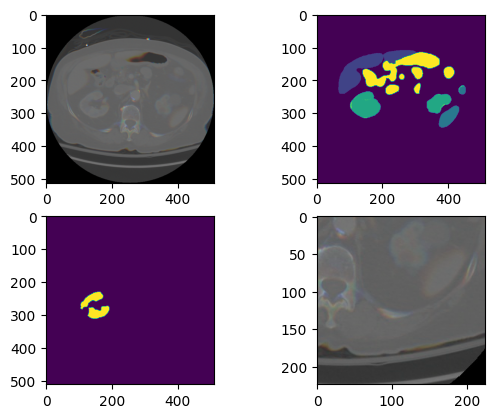

In [33]:
show_id = 62
show_organ = 3
img_list = create_3ch_image(show_id)
image = np.stack(img_list).transpose(1,2,0)
print(image.max(),image.min())
cv2.imwrite("tmp_vis.jpeg",image[:,:,0]*255.0)
mmdet_mask = get_mask_mmdet("tmp_vis.jpeg")
y_z = np.where(mmdet_mask==show_organ)
best_y =min(max(int(np.mean(y_z[0])-112), 0), mask_img.shape[1]-224)
best_z =min(max(int(np.mean(y_z[1])-112), 0), mask_img.shape[1]-224)
print("best y and z",best_y, best_z)
plt.subplot(2,2,1);plt.imshow(image)
plt.subplot(2,2,2);plt.imshow(mmdet_mask)#[best_y:best_y+224,best_z:best_z+224])
print("mmdet size", np.sum(mmdet_mask==show_organ))
plt.subplot(2,2,3);plt.imshow(get_mask_smp(image)==show_organ)
print("smp size", np.sum(get_mask_smp(image)==show_organ))
plt.subplot(2,2,4);plt.imshow(cv2.imread(f"./cropped_images{r_folder}/{r_pid}_{r_sid}_{rewrite_organ}_{show_id}.jpeg"))
"./train_images/"

0 230
0 255
0 198
0 89
48 166
0 234


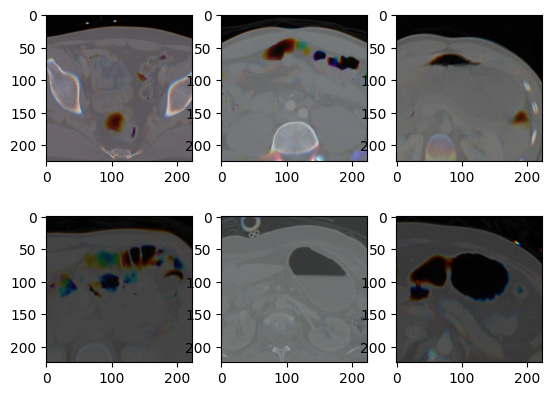

In [34]:

images_coords = [239-112, 180-112] #liver
folder = "cropped_images_3ch"
for ii in range(6):
    gt_sid = np.random.choice(bowel_healthy_sids)
    gt_pid = s_id_p_id[gt_sid]
    # gt_sid = glob(f"./train_images/{gt_pid}/*")[0].split("\\")[-1]
    img = cv2.imread(glob(f"./{folder}/{gt_pid}_{gt_sid}_{5}_*.jpeg")[0])
    print(img.min(),img.max())
    plt.subplot(2,3,ii+1)
    plt.imshow(img)

79 179
76 255
79 181
78 196
137 239
185 244


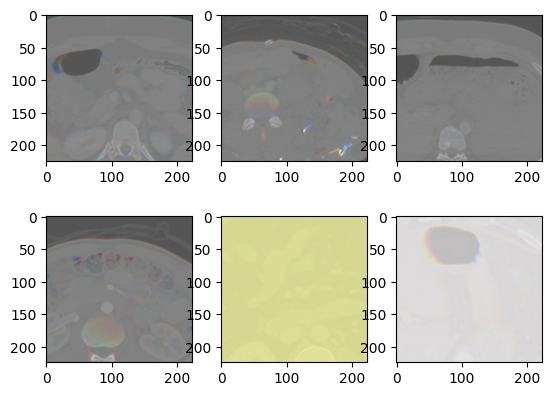

In [35]:

images_coords = [239-112, 180-112] #liver
folder = "cropped_images_3ch"
for ii in range(6):
    gt_sid = np.random.choice(bowel_injury_sids)
    gt_pid = s_id_p_id[gt_sid]
    # gt_sid = glob(f"./train_images/{gt_pid}/*")[0].split("\\")[-1]
    img = cv2.imread(glob(f"./{folder}/{gt_pid}_{gt_sid}_{5}_*.jpeg")[0])
    print(img.min(),img.max())
    plt.subplot(2,3,ii+1)
    plt.imshow(img)

19 93
0 116
0 246
75 255
115 255
0 144


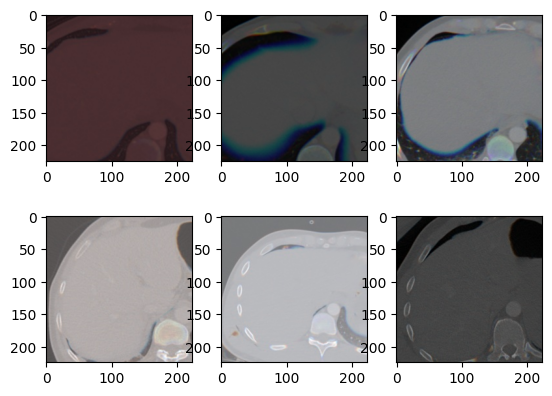

In [36]:
images_coords = [239-112, 180-112]
cid = 1
for ii in range(6):
    gt_sid = np.random.choice(liver_low_sids)
    gt_pid = s_id_p_id[gt_sid]
    # gt_sid = glob(f"./train_images/{gt_pid}/*")[0].split("\\")[-1]
    img = cv2.imread(glob(f"./{folder}/{gt_pid}_{gt_sid}_{cid}_*.jpeg")[0])
    print(img.min(),img.max())
    plt.subplot(2,3,ii+1)
    plt.imshow(img)

52416 54830 55 212
50486 56245 0 224
3983 19468 0 224
22758 13287 0 139
47040 54828 0 246
32664 58501 72 255


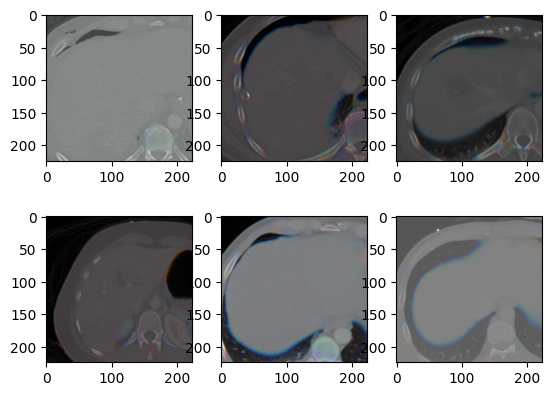

In [37]:
images_coords = [239-112, 180-112]
for ii in range(6):
    gt_sid = np.random.choice(liver_low_sids)
    gt_pid = s_id_p_id[gt_sid]
    # gt_sid = glob(f"./train_images/{gt_pid}/*")[0].split("\\")[-1]
    img = cv2.imread(glob(f"./{folder}/{gt_pid}_{gt_sid}_{1}_*.jpeg")[0])
    print(gt_pid,gt_sid,img.min(),img.max())
    plt.subplot(2,3,ii+1)
    plt.imshow(img)

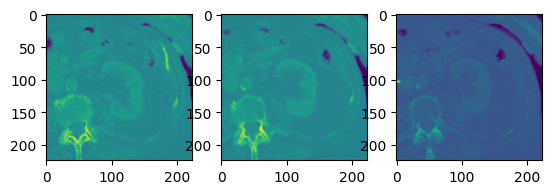

In [38]:
# colorful 3 channel image
tmp_img = cv2.imread("./cropped_images_3ch/11770_11416_3_29.jpeg")
for ii in range(3):
    plt.subplot(1,3,ii+1);plt.imshow(tmp_img[:,:,ii])

76 174
0 160
48 181
48 181
0 229
57 204


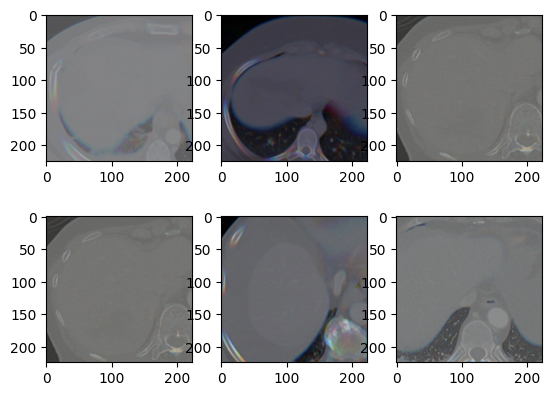

In [39]:
images_coords = [239-112, 180-112]
for ii in range(6):
    gt_sid = np.random.choice(liver_high_sids)
    gt_pid = s_id_p_id[gt_sid]
    # gt_sid = glob(f"./train_images/{gt_pid}/*")[0].split("\\")[-1]
    img = cv2.imread(glob(f"./{folder}/{gt_pid}_{gt_sid}_{cid}_*.jpeg")[0])
    print(img.min(),img.max())
    plt.subplot(2,3,ii+1)
    plt.imshow(img)

process 50021 53973
0.0 1.0
process 24538 48638
0.0 1.0
process 21293 27585
0.0 1.0
process 56689 62596
0.0 1.0
process 63113 60046
0.0 1.0
process 14654 59721
0.0 1.0


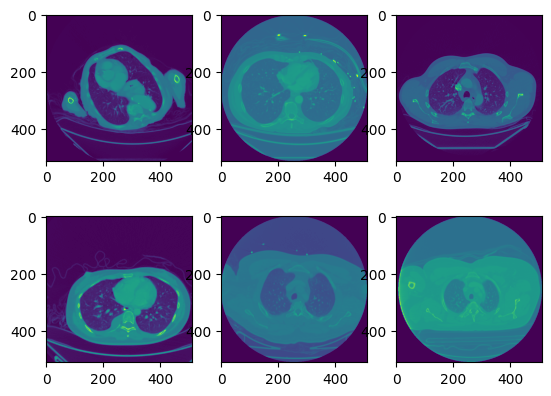

In [40]:

images_coords = [239-112, 180-112]
for ii in range(6):
    gt_sid = np.random.choice(spleen_healthy_sids)
    gt_pid = s_id_p_id[gt_sid]
    image_paths = glob(f"./train_images/{gt_pid}/{gt_sid}/*.dcm")
    image_paths = sorted(image_paths,key=lambda x:int(x.split("\\")[-1].replace(".dcm","")))
    img_idx = 0
    print("process", gt_pid,gt_sid)
    if len(glob(f"./224files/{gt_pid}_{gt_sid}_coord.npy")):
        coords = np.load(glob(f"./224files/{gt_pid}_{gt_sid}_coord.npy")[0])
        img_idx = coords[0][0] 
        print("has coord npy", img_idx)
    elif len(glob(f"./segmentations/{gt_sid}.nii")):
        print("has seg nii")
        masks = nib.load(glob(f"./segmentations/{gt_sid}.nii")[0])
        img_idx = np.where(masks==1)[0][0]
    # image_paths = glob(f"./224files/{trn_df.iloc[800].patient_id}*.jpeg")
    # image_paths = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/{trn_df.iloc[800].patient_id}/*/*.jpeg")
    img = load_dicom(image_paths[img_idx])
    print(img.min(),img.max())
    plt.subplot(2,3,ii+1)
    plt.imshow(img)

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


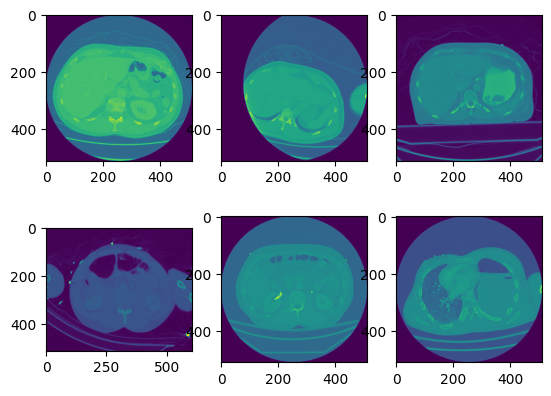

In [41]:
import pydicom as dicom

images_coords = [239-112, 180-112]
for ii in range(6):
    gt_sid = np.random.choice(spleen_healthy_sids)
    gt_pid = s_id_p_id[gt_sid]
    image_paths = glob(f"./train_images/{gt_pid}/*/*.dcm")
    image_paths = sorted(image_paths,key=lambda x:int(x.split("\\")[-1].replace(".dcm","")))
    # image_paths = glob(f"./224files/{trn_df.iloc[800].patient_id}*.jpeg")
    # image_paths = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/{trn_df.iloc[800].patient_id}/*/*.jpeg")
    img = load_dicom(image_paths[100])
    print(img.min(),img.max())
    plt.subplot(2,3,ii+1)
    plt.imshow(img)

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


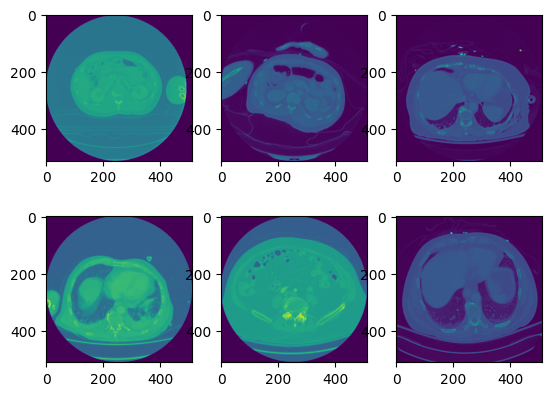

In [42]:
import pydicom as dicom

images_coords = [239-112, 180-112]
for ii in range(6):
    gt_sid = np.random.choice(spleen_high_sids)
    gt_pid = s_id_p_id[gt_sid]
    image_paths = glob(f"./train_images/{gt_pid}/*/*.dcm")
    image_paths = sorted(image_paths,key=lambda x:int(x.split("\\")[-1].replace(".dcm","")))
    # image_paths = glob(f"./224files/{trn_df.iloc[800].patient_id}*.jpeg")
    # image_paths = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/{trn_df.iloc[800].patient_id}/*/*.jpeg")
    img = load_dicom(image_paths[100])
    print(img.min(),img.max())
    plt.subplot(2,3,ii+1)
    plt.imshow(img)

In [43]:
# dcm_folder = glob(f"./train_images/*/*")
# for dcm_f in dcm_folder:
#     dcm_img = load_dicom(glob(f"{dcm_f}/*.dcm")[0]).shape
#     if dcm_img!=(512,512): print(dcm_img)

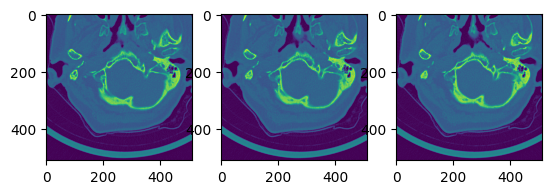

In [44]:
for i in range(3):
    plt.subplot(1,3,i+1)
    vert_dcm = load_dicom(f"G:/RSNA2022RAWE/1.2.826.0.1.3680043.10633/{100+i}.dcm")
    plt.imshow(vert_dcm)

In [45]:
vert_mask = nib.load("G:/RSNA2022RAWE/1.2.826.0.1.3680043.10633/1.2.826.0.1.3680043.10633.nii")
vert_mask = vert_mask.get_fdata()[:, ::-1, ::-1].transpose(2,1,0)
print(vert_mask.shape, np.unique(vert_mask))

(429, 512, 512) [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


In [46]:
trn_csv = pd.read_csv("G:/rsna-2022-cervical-spine-fracture-detection/train.csv")
trn_csv

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0      1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0
1     1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0
2     1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0
3     1.2.826.0.1.3680043.12351                0   0   0   0   0   0   0   0
4      1.2.826.0.1.3680043.1363                1   0   0   0   0   1   0   0
...                         ...              ...  ..  ..  ..  ..  ..  ..  ..
2014  1.2.826.0.1.3680043.21684                1   0   1   0   0   0   1   1
2015   1.2.826.0.1.3680043.4786                1   0   0   0   0   0   0   1
2016  1.2.826.0.1.3680043.14341                0   0   0   0   0   0   0   0
2017  1.2.826.0.1.3680043.12053                0   0   0   0   0   0   0   0
2018  1.2.826.0.1.3680043.18786                1   0   0   0   0   0   0   1

[2019 rows x 9 columns]

In [49]:
segment_files = glob(f"G:/rsna-2022-cervical-spine-fracture-detection/segmentations/*.nii")
segment_names = [x.split("\\")[-1].replace(".nii","") for x in segment_files]
seg_df = pd.DataFrame({"StudyInstanceUID":segment_names}).merge(trn_csv,on="StudyInstanceUID",how="left")
seg_df

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0   1.2.826.0.1.3680043.10633                0   0   0   0   0   0   0   0
1   1.2.826.0.1.3680043.10921                0   0   0   0   0   0   0   0
2   1.2.826.0.1.3680043.11827                1   0   1   0   0   0   0   0
3   1.2.826.0.1.3680043.11988                1   0   0   0   0   1   1   0
4   1.2.826.0.1.3680043.12281                0   0   0   0   0   0   0   0
..                        ...              ...  ..  ..  ..  ..  ..  ..  ..
82   1.2.826.0.1.3680043.8330                1   0   0   0   0   1   1   1
83   1.2.826.0.1.3680043.8574                0   0   0   0   0   0   0   0
84   1.2.826.0.1.3680043.8744                0   0   0   0   0   0   0   0
85   1.2.826.0.1.3680043.8884                0   0   0   0   0   0   0   0
86   1.2.826.0.1.3680043.9926                1   0   1   0   0   0   0   0

[87 rows x 9 columns]

In [52]:
print(len(trn_csv),len(seg_df))
for Cid in range(1,8):
    print(np.sum(trn_csv[f"C{Cid}"].values), np.sum(seg_df[f"C{Cid}"].values))

2019 87
146 5
285 13
73 11
108 9
162 14
277 20
393 13


In [ ]:
seg_C1 = seg_df[seg_df.C1==0]
len(seg_C1)

82

0
(369, 512, 512)
1
(298, 512, 512)
2
(462, 512, 512)
3
(433, 512, 512)
4
(586, 512, 512)
5
(409, 512, 512)


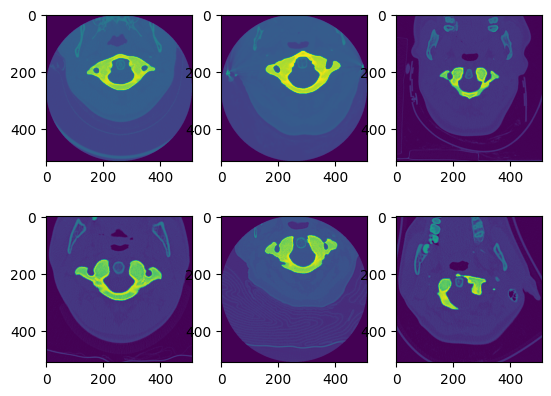

In [ ]:
vert_cls = 1
for ii in range(6):
    print(ii)
    tmp_id = np.random.choice(seg_C1.StudyInstanceUID)
    vert_mask = nib.load(f"G:/rsna-2022-cervical-spine-fracture-detection/segmentations/{tmp_id}.nii")
    vert_mask = vert_mask.get_fdata()[:, ::-1, ::-1].transpose(2,1,0) == vert_cls
    vert_mask = vert_mask.astype(np.float32)
    print(vert_mask.shape)
    max_idx = np.argmax(vert_mask.sum(1).sum(1))
    img_files = glob(f"G:/rsna-2022-cervical-spine-fracture-detection/train_images/{tmp_id}/*")
    img_files = sorted(img_files, key=lambda x:int(x.split("\\")[-1].replace(".dcm","")))
    tmp_img = load_dicom(img_files[max_idx])
    plt.subplot(2,3,ii+1);plt.imshow(np.where(vert_mask[max_idx],tmp_img+vert_mask[max_idx],tmp_img))
    

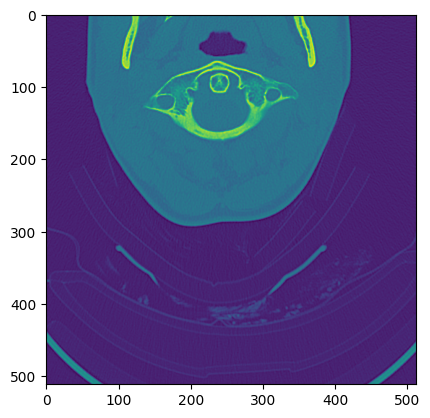

In [ ]:
plt.imshow(tmp_img)

In [ ]:
img_files[max_idx]

'G:/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.32434\\107.dcm'

In [ ]:
tmp_img

In [ ]:
vert_mask[max_idx]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
np.unique(vert_mask)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

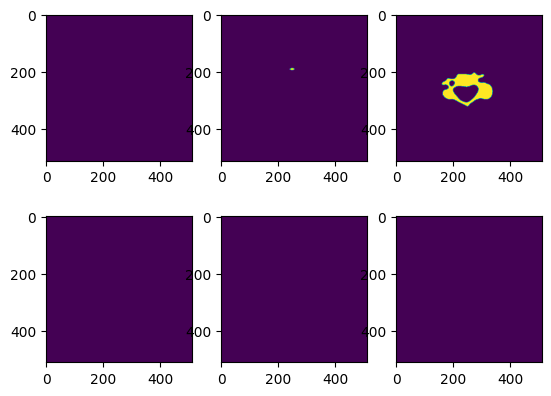

In [ ]:
for mid in range(6):
    plt.subplot(2,3,mid+1);plt.imshow(vert_mask[200]==mid+1)

In [ ]:
cropped = np.load("G:/RSNA2022RAWE/cropped_2d_224_15_ext0_5ch_0920_2m/1.2.826.0.1.3680043.10633_1_0.npy")
plt.imshow(cropped)

In [ ]:
# image_paths = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/*/*/*.jpeg")
# cv2.imread(image_paths[0]).max()

In [ ]:
os.getcwd()

'G:\\rsna-2023-abdominal-trauma-detection'

In [ ]:
list(glob("./models/vit*"))

['./models\\vit0919_model_0_0.pth',
 './models\\vit0919_model_0_1.pth',
 './models\\vit0919_model_1_0.pth',
 './models\\vit0919_model_2_0.pth',
 './models\\vit0919_model_3_0.pth',
 './models\\vit_spleen_0_3labels_0927.pth',
 './models\\vit_spleen_1_3labels_0927.pth',
 './models\\vit_spleen_2_3labels_0927.pth',
 './models\\vit_spleen_3_3labels_0927.pth']

In [ ]:
list(glob("./models/resnet*"))

['./models\\resnet_liver_1_3labels_0927.pth',
 './models\\resnet_liver_2_3labels_0927.pth',
 './models\\resnet_liver_3_3labels_0927.pth',
 './models\\resnet_spleen_0_3labels_0927.pth',
 './models\\resnet_spleen_1_3labels_0927.pth']

In [ ]:
trn_df.columns

Index(['patient_id', 'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high', 'any_injury'],
      dtype='object')

In [ ]:
len(test_img_list)
# len(test_img_list[2])
gt_target = []
pred_target = []
images_coords = [239-112, 180-112]
test_img_list = []
torch.cuda.empty_cache()